In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Visualización Redes

Generamos una red aleatoria con n nodos y cantidad de conexiones m

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


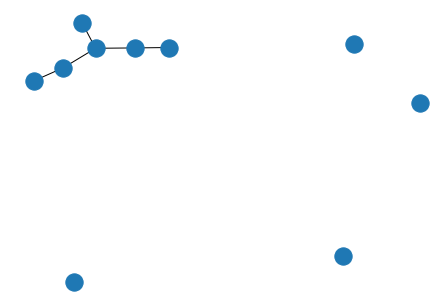

In [2]:
n = 10
m = 5 # tiene que ser menor que n*(n-1)/2

# Con numpy 
A = np.zeros((n,n))
r,c = np.triu_indices(n,1)
ix = np.random.choice(np.arange(len(r)), m, replace=False)
r = r[ix]
c = c[ix]
A[r,c] = 1
A = A + A.T
print(A)
G = nx.from_numpy_array(A)
nx.draw(G)

Con cantidad de nodos n y conexiones con probabilidad p

In [3]:
# Con networkx
n = 10
p = 0.8
G = nx.erdos_renyi_graph(n, p)
print(nx.adjacency_matrix(G).todense())
nx.draw(G)

/tmp/ipykernel_16654/455134032.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  print(nx.adjacency_matrix(G).todense())


AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

# Crear redes a partir de nubes de puntos



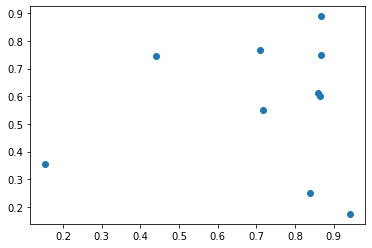

In [4]:
n = 10
x = np.random.rand(n)
y = np.random.rand(n)
X = np.vstack([x,y]).T
plt.scatter(x,y);

Distancia euclídea todos con todos, método pdist de scipy

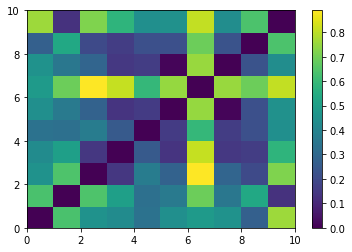

In [5]:
from scipy.spatial.distance import pdist, squareform
C = squareform(pdist(X))

plt.pcolor(C)
plt.colorbar();

## Ejercicio: 
Dados distintos umbrales, construir redes a partir de la matriz de distancias anterior.

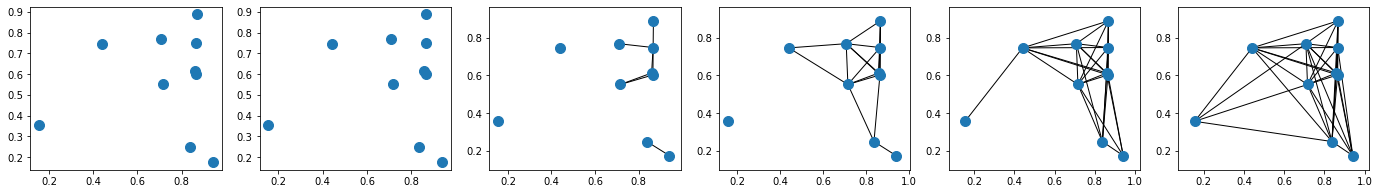

In [6]:
pos = {i:p for i,p in enumerate(zip(x,y))}

k = 5
# k +1 porque sumamos el item distancia 0.
f, axs = plt.subplots(1, k+1, figsize=(24,3))
min_non_0 = np.min(C[np.nonzero(C)])
ee = np.concatenate( ([0], np.linspace(min_non_0, C.max() * 0.8, k)))
## print(ee)
for i, u in enumerate(ee):
  # CAMBIO - Construir matriz de adyacencia para el umbral U - ojo < vs <=
  A = (C<=u).astype(int)
  # CAMBIO - Construir grafo 
  A = A - np.diag(np.diag(A))
  G = nx.from_numpy_array(A)
  # Plotear red
  nx.draw_networkx_nodes(G,pos=pos,ax=axs[i], node_size=100)
  nx.draw_networkx_edges(G,pos=pos,ax=axs[i])
  axs[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

Nota: 
Si en vez de puntos que toman valores continuos en este caso en R², se tienen vectores con valores 0 o 1, una forma de medir distancia o similaridad es el producto interno entre los pares de puntos.

# Metodo de la potencia

## Ejercicio:

Implementar el método de la potencia considerando algún criterio de parada

In [7]:
#@title
import numpy as np
from numpy import linalg as LA

### CAMBIO

def power_iteration(A, niter=1000, eps=1e-6):
    b = np.random.rand(A.shape[1])
    b = b / np.linalg.norm(b)

    for i in range(niter):
        old = b
        b = A @ b
        b = b / np.linalg.norm(b)

        # Criterio de parada
        # <a, b> = |a| |b| cos(angle)
        # -1 < cos(angle) < 1
        ## IMPORTANTE - criterio de parada adicional a niter > acelero el corte del método.
        ## Otros criterios de convergencia: angulo A*x ~ w*x
        cos_angle = np.dot(b, old)
        if (1 - eps) < cos_angle <= 1:
            print(f"Paré en la iteración {i+1}")
            break

    eigenvalue = np.dot(b, A @ b)

    return eigenvalue, b



Verifiquemos la implementación un ejemplo conocido:

$$
A = Q^T \begin{pmatrix}
d_1    &0     &0      &0      &\\
0      &d_2   &0      &0      &\\
\vdots &\vdots&\ddots &\vdots &\\
0      &0     &0      &d_n    & \\
\end{pmatrix} Q 
$$

con $Q = I - 2 v v^T$, $||v||_2=1$
 la matriz de reflexión que sabemos que es ortogonal

Probemos calcular el método de la potencia con esto.

In [8]:
#@title
import numpy as np

D = np.diag([5.0, 4.0, 3.0, 2.0, 1.0])

v = np.ones((D.shape[0], 1))

v = v / np.linalg.norm(v)

# Matriz de Householder
B = np.eye(D.shape[0]) - 2 * (v @ v.T)

# Matriz a diagonalizar
M = B.T @ D @ B

power_iteration(M)

Paré en la iteración 31


(4.999979040433682,
 array([-0.5981623 ,  0.39724905,  0.40182686,  0.40182722,  0.40182722]))

# Metodo de la potencia + Deflación

Implementar método de la potencia + deflación

In [9]:

### CAMBIO

def eigen(A, num, **kwargs):
    A = A.copy()
    eigenvalues = []
    eigenvectors = np.zeros((A.shape[0], num))
    
    for i in range(num):
        print(f"Autovalor {i+1}")
        l, v = power_iteration(A, **kwargs)

        eigenvalues.append(l)
        eigenvectors[:, i] = v
        A = A - l * np.outer(v, v)
        print(A)
        
    return np.array(eigenvalues), eigenvectors


## Casos de prueba para "jugar"

Matriz de Householder y Matriz Diagonal.

In [10]:
D = np.diag(range(10, 0, -1))
print(D)
v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)

# Matriz de Householder
B = np.eye(D.shape[0]) - 2 * (v @ v.T)

# Matriz a diagonalizar
M = D

#@title

l, v = power_iteration(M, niter=1000, eps=1e-6)

#@title
l, v

#@title
N = 10
D = np.diag(range(N, 0, -1))

v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)

# Matriz de Householder
B = np.eye(D.shape[0]) - 2 * (v @ v.T)

M = B.T @ D @ B
# Para todos los eigen el ejemplo anterior de householder.
l, v = eigen(M, N, niter=5_000)
print(l)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  1]]
Paré en la iteración 52
Autovalor 1
Paré en la iteración 32
[[ 1.84164628 -0.08392044  0.21251558  0.41485828  0.61490031  0.81490083
   1.01490083  1.21490083  1.41490083  1.61490083]
 [-0.08392044  7.23850749 -1.58448661 -1.38504521 -1.18505523 -0.98505535
  -0.78505535 -0.58505535 -0.38505535 -0.18505535]
 [ 0.21251558 -1.58448661  6.59105665 -1.20953748 -1.00954813 -0.80954827
  -0.60954827 -0.40954827 -0.20954827 -0.00954827]
 [ 0.41485828 -1.38504521 -1.20953748  5.98986754 -0.81014314 -0.61014327
  -0.41014327 -0.21014327 -0.01014327  0.18985673]
 [ 0.61490031 -1.18505523 -1.00954813 -0.81014314  5.38984619 -0.41015394
  -0.21015394 -0.01015394  0.189846

Otros ejemplos

In [11]:

#@title
# CASO SIMETRICO
A = np.array([
  [ 7,  2,  -3],
  [ 2,  2,  -2],
  [-3, -2,  -2]
])
w, V = eigen(A, num=3, niter=20000, eps=1e-24)
for i in range(len(A)):
    print(i)
    print(np.allclose(A @ V[:, i], w[i] * V[:,i]))
print("Gracias teorema espectral! (ver pdf teórico)")  

#@title
# CASO (A) * (A traspuesta)
AT = A @ A.T
TA = A.T @ A
wta, VTA = eigen(AT, num=3, niter=20000, eps=1e-24)
wat, VAT = eigen(TA, num=3, niter=20000, eps=1e-24)
print("Bingo :)" if np.allclose(wat,wta) else "Bongo :(")

Autovalor 1
[[ 0.08451057 -0.72971571 -0.58211356]
 [-0.72971571  0.9225133  -1.04560007]
 [-0.58211356 -1.04560007 -2.84537398]]
Autovalor 2
[[ 0.24433757 -0.53328447  0.09677828]
 [-0.53328447  1.16393203 -0.21122562]
 [ 0.09677828 -0.21122562  0.03833236]]
Autovalor 3
[[-3.05311332e-15 -1.22124533e-15  1.04083409e-15]
 [-1.22124533e-15 -4.44089210e-16  4.44089210e-16]
 [ 1.04083409e-15  4.44089210e-16 -9.02056208e-17]]
0
True
1
True
2
True
Gracias teorema espectral! (ver pdf teórico)
Autovalor 1
[[ 0.87848326 -0.12618316  2.37012684]
 [-0.12618316  2.47679533  2.43532068]
 [ 2.37012684  2.43532068  9.5282888 ]]
Autovalor 2
[[ 0.35345921 -0.77145037  0.13999966]
 [-0.77145037  1.68374637 -0.3055594 ]
 [ 0.13999966 -0.3055594   0.05545167]]
Autovalor 3
[[ 3.66928710e-14  1.45439216e-14 -1.19071419e-14]
 [ 1.45439216e-14  6.21724894e-15 -4.66293670e-15]
 [-1.19071419e-14 -4.66293670e-15  4.98212582e-15]]
Autovalor 1
[[ 0.87848326 -0.12618316  2.37012684]
 [-0.12618316  2.47679533  2.43

¿Y este? 

In [12]:
#@title
# CASO
A = np.array([
  [7, 2, 3],
  [0, 2, 0],
  [-6, -2, -2]
])

w, V = eigen(A, num=3, niter=20000, eps=1e-24)
print("w")
print(w)
print("V")
print(V)

#@title
print(A)
for i in range(len(A)):
    print(i)
    print(np.allclose(A @ V[:, i], w[i] * V[:,i]))  

#@title
print("uso una biblioteca")
w2, V2 = LA.eig(A)
print(w2)
print(V2)
print(np.dot(V2[:,0],V2[:,2]))
print(np.dot(V2[:,0],V2[:,1]))
print(np.dot(V2[:,2],V2[:,1])) 

Autovalor 1
[[ 5.  2.  5.]
 [ 0.  2.  0.]
 [-4. -2. -4.]]
Autovalor 2
[[ 4.33333333  1.33333333  5.66666667]
 [-0.66666667  1.33333333  0.66666667]
 [-3.33333333 -1.33333333 -4.66666667]]
Autovalor 3
[[ 4.30894309  1.18699187  5.71544715]
 [-0.81300813  0.45528455  0.95934959]
 [-3.28455285 -1.04065041 -4.76422764]]
w
[4. 2. 1.]
V
[[ 0.70710678  0.57735027 -0.15617376]
 [ 0.          0.57735027 -0.93704257]
 [-0.70710678 -0.57735027  0.31234752]]
[[ 7  2  3]
 [ 0  2  0]
 [-6 -2 -2]]
0
True
1
False
2
False
uso una biblioteca
[4. 1. 2.]
[[ 0.70710678 -0.4472136  -0.57735027]
 [ 0.          0.          0.57735027]
 [-0.70710678  0.89442719  0.57735027]]
-0.8164965809277259
-0.9486832980505137
0.7745966692414833


<div>
<img src="https://i.pinimg.com/564x/d6/17/5f/d6175ff06b5636c83773b74b92f7f5b8.jpg" width="200">
</div>


# Analisis de autovectores en redes

## Propiedades de la matriz L

* Es semi-definida positiva.
* Cada fila y columna suma cero.
* El vector (1, 1, 1,.... 1) está en el núcleo. Luego, la matriz es singular.
* El número de componentes conexas es igual a la dimensión del núcleo.
* La traza (suma de la diagonal) es igual a 2 * cantidad de ejes de la red subyacente.

## Ejercicio: 
Experimentar con al menos dos redes pequeñas y corroborar la propiedad 4.

Además, para cada caso sacar conclusiones sobre la centralidad de autovector (usando el de mayor autovalor) y la conectividad algebraica.


Cantidad de componentes
(10, 5)
2.000000000000001

centralidad
2.000000000000001
[0.28867513 0.28867513 0.         0.57735027 0.         0.28867513
 0.57735027 0.         0.28867513 0.        ]
6

conectividad
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[False False False False False False  True False False False]


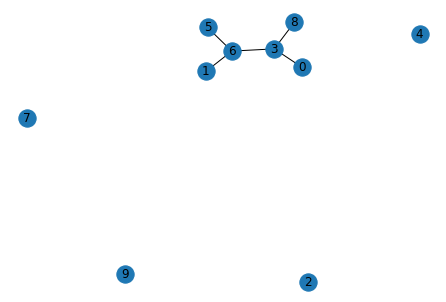

In [13]:
from scipy.linalg import null_space
from scipy.sparse.csgraph import laplacian
from numpy import linalg as LA
## CAMBIO
n = 10 # 
m = 5# tiene que ser menor que n*(n-1)/2 - max=45

# (A) Con numpy - random
A = np.zeros((n,n))
r,c = np.triu_indices(n,1)
ix = np.random.choice(np.arange(len(r)), m, replace=False)
r = r[ix]
c = c[ix]
A[r,c] = 1
A = A + A.T

# print(A)
G = nx.from_numpy_array(A)
nx.draw(G, with_labels=True)
## Calculo la la placiana
Z = null_space(laplacian(A))
print("Cantidad de componentes")
print(Z.shape)

# Centralidad de autovector.
w, v = LA.eig(A) 
print(np.sort(w)[-1])

## Ahora ordeno todo junto.
idx = w.argsort()[::-1]   
eigenValues = w[idx]
eigenVectors = v[:,idx]

print("")
print("centralidad")
print(eigenValues[0])
print(eigenVectors[:,0])
## Ojo el signo, para ver valor absoluto.
print(np.argmax(np.abs(eigenVectors[:,0])))
##print(idx)

# Conectividad algebraica (auto valor)
print("")
print("conectividad")
idx = np.where(eigenValues > 0, eigenValues, np.inf).argmin()
print(eigenVectors[idx])
print(eigenVectors[idx] > 0)


[('A', '0.32'),
 ('B', '0.63'),
 ('C', '0.46'),
 ('D', '0.46'),
 ('E', '0.13'),
 ('F', '0.26')]

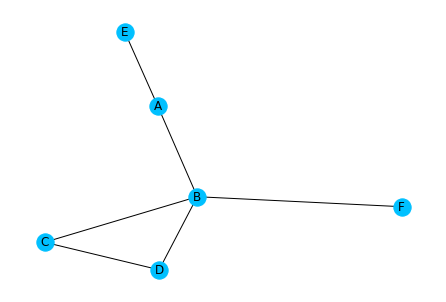

In [27]:
## (B) Un ejemplo.

n = 6
m = 6
G= nx.Graph()
G.add_edge("A","E")
G.add_edge("A","B")
G.add_edge("B","F")
G.add_edge("B","C")
G.add_edge("B","D")
G.add_edge("C","D")
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G,pos=pos,with_labels = True,node_color='#00c0ff')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)


centrality = nx.eigenvector_centrality(G)

sorted((v, f"{c:0.2f}") for v, c in centrality.items())

## Ejercicio:


1.  Analizar el espectro de autovalores de la Laplaciana para redes de 10 nodos en función de su densidad de ejes. Para cada densidad, considerar el promedio y la dispersión del espectro generando varias redes aleatorias. Para mostrar los resultados del análisis recurrir a alguna representación gráfica adecuada que muestre en fucnción del parámetro relevante:


> la evolución de la magnitud de los autovalores en promedio,


> la dispersión de esas magnitudes.


2. Comparar los resultados obtenidos utilizando su implementacion del método de la potencia + deflación






Considerar [este](https://networkx.org/documentation/stable/reference/generated/networkx.linalg.spectrum.laplacian_spectrum.html
) y este [otro](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html) método para conseguir el espectro



In [15]:
ls  = []
rep = 50 # cantidad repeticiones
n = 10  # cantidad de nodos
rp = 50 # cantidad de densidades

for p in np.linspace(0,1, rp):
  l = np.zeros(n)
  for r in range(rep):
    ## CAMBIO
    ## genero una rede de n nodos con una densidad que depende de p.
    Gx = nx.erdos_renyi_graph(n,p)
    ne = Gx.number_of_edges()
    # CAMBIO
    # guardo los autovalores.
    l = [ne] + sorted(nx.laplacian_spectrum(Gx))
    ls.append( l )

## Generar figura en función de lo pedido y la información acmulada en el paso previo.
## CAMBIO

plt.figure(figsize=(8,6))
u = pd.DataFrame(ls).groupby(0).mean()
s = pd.DataFrame(ls).groupby(0).std()
for i in range(1,11):
  plt.plot(u[i], label=i)
  plt.fill_between(u.index, y1=u[i]-s[i],y2=u[i]+s[i], alpha=0.3)

plt.xlabel('Cantidad de conexiones')
plt.ylabel('Valor')
plt.legend(loc=(1.04,0.15), fontsize=12, title='Autovalor');

## Qué es la raja azúl de abajo #####

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

# PCA y reconstrucción de rostros

In [16]:
from pathlib import Path
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [17]:

### CAMBIO

!wget https://www.dropbox.com/s/m61soq8700l6fpv/caras.csv

--2022-10-24 00:11:32--  https://www.dropbox.com/s/m61soq8700l6fpv/caras.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/m61soq8700l6fpv/caras.csv [following]
--2022-10-24 00:11:33--  https://www.dropbox.com/s/raw/m61soq8700l6fpv/caras.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbf3ddd940b40d0763a856a9b2a.dl.dropboxusercontent.com/cd/0/inline/Bva_qw_Ac17dWnVSbnAjfRpaxD1aEln6zaIG4Emd7rvLk37noTUzbSpb-49pXu9M-vYcr2_lu0xG7_54y-vmfQ5WFRKqVID6rwmFR1vxAyTs1NDWt8k4maCl4XKkz5m4zt5CFBKzUxXiQrUkGAGuKk9PNebOz56mTYqDTf3cM_QuOA/file# [following]
--2022-10-24 00:11:33--  https://ucbf3ddd940b40d0763a856a9b2a.dl.dropboxusercontent.com/cd/0/inline/Bva_qw_Ac17dWnVSbnAjfRpaxD1aEln6zaIG4Emd7rvLk37noTUzbSpb-49pXu9M-vYcr2_lu0xG7_54y-vmfQ5WF

In [18]:
X = pd.read_csv('caras.csv').values
X.shape

FileNotFoundError: [Errno 2] File b'caras.csv' does not exist: b'caras.csv'

In [ ]:
h,w = 112//2, 92//2

In [ ]:
f, axs = plt.subplots(10,10, figsize=(24,24))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(X[i].reshape(h,w), cmap=plt.cm.gray);
  ax.axis('off')
plt.tight_layout()

In [19]:
Xcentered = X - X.mean(0)
print(X.shape)
l, V = np.linalg.eigh(Xcentered.T@Xcentered/X.shape[0])

(10, 2)


Notar que V son los autovectores de la matriz de covarianza puestos como columnas. La función los devuelve ordenados de manera ascendente.

In [20]:
V.shape

(2, 2)

¿Qué pinta tienen los autovectores de la matriz de covarianza?

NameError: name 'h' is not defined

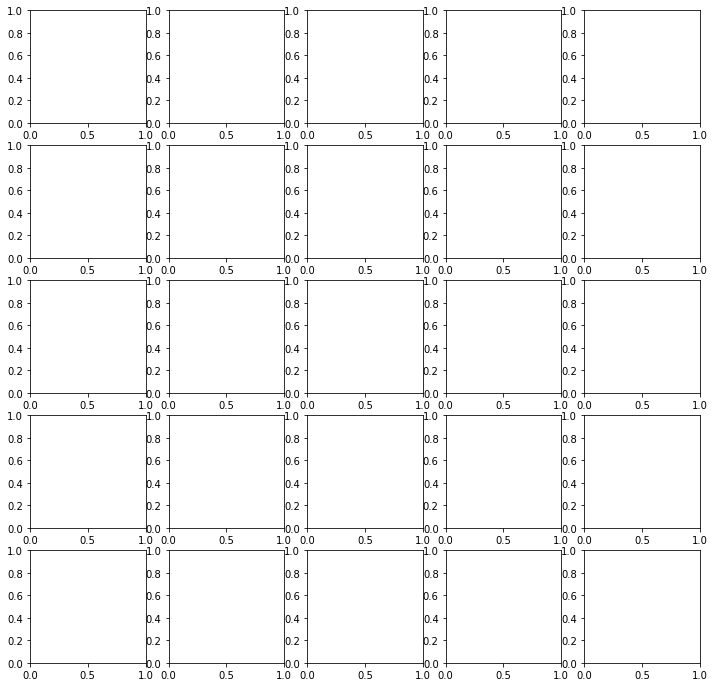

In [21]:
f, axs = plt.subplots(5,5, figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(V[:,-i-1].reshape(h,w), cmap=plt.cm.gray);
  ax.axis('off')
plt.tight_layout()

Ahora simplemente apr

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(50).fit(X)

In [22]:
pca.components_.shape

NameError: name 'pca' is not defined

NameError: name 'pca' is not defined

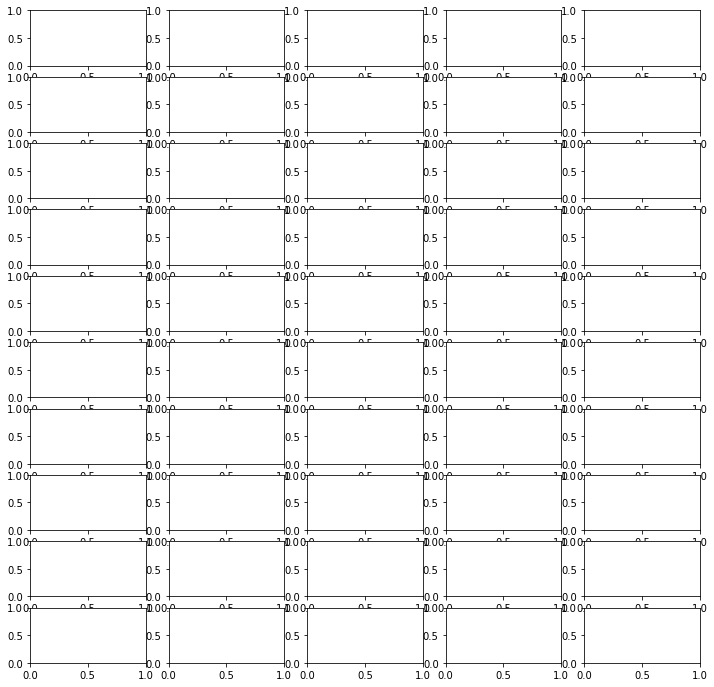

In [23]:
f, axs = plt.subplots(10,5, figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(pca.components_[i].reshape(h,w), cmap=plt.cm.gray);
  ax.axis('off')
plt.tight_layout()

Más componentes más se explica la varianza total, con 50 ya se llega al 95% aprox

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));

Conseguimos las coordenadas de las 50 componentes principales (eigenfaces). 

In [24]:
Z = pca.transform(X)

NameError: name 'pca' is not defined

Ahora podemos expresar cualquier cara como una combinación lineal de las eigenfaces anteriores. Veamos que tan bien resulta la aproximación con una mera inspección visual.

## Ejercicio: 
Aproximar las caras del dataset utilizando 50 componentes principales


NameError: name 'pca' is not defined

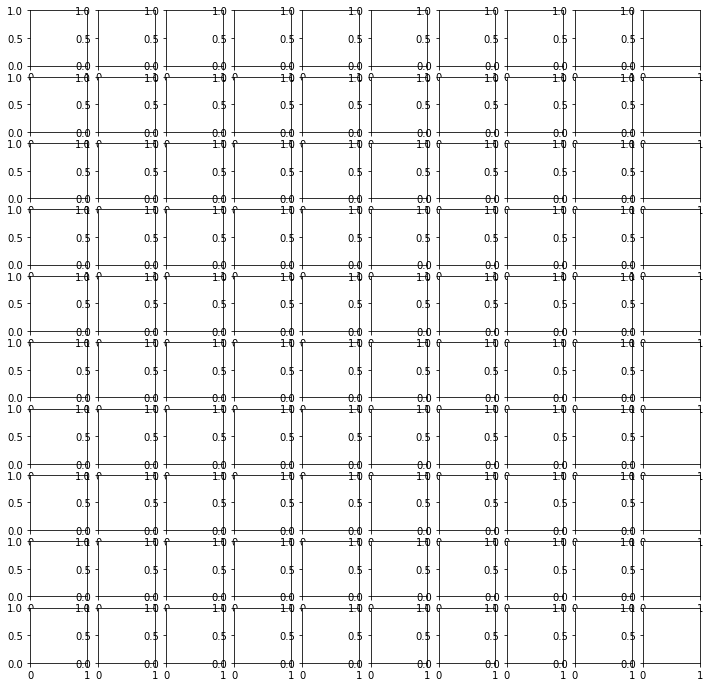

In [25]:

### CAMBIO
### CAMBIO
f, axs = plt.subplots(10,10, figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
  ## 
  ax.imshow(np.sum((np.outer(Z[i], np.array([1]*2576)) * pca.components_ ), axis=0).reshape(h,w), cmap=plt.cm.gray);
  ax.axis('off')
plt.tight_layout()
pca.components_.shape


In [ ]:
C = Xcentered @ Xcentered.T /2576/255/255

In [ ]:
C.shape

Producto interno entre cada par de imágenes. Se ve estructura de bloques porque se repite la persona en grupos de 10 imágenes

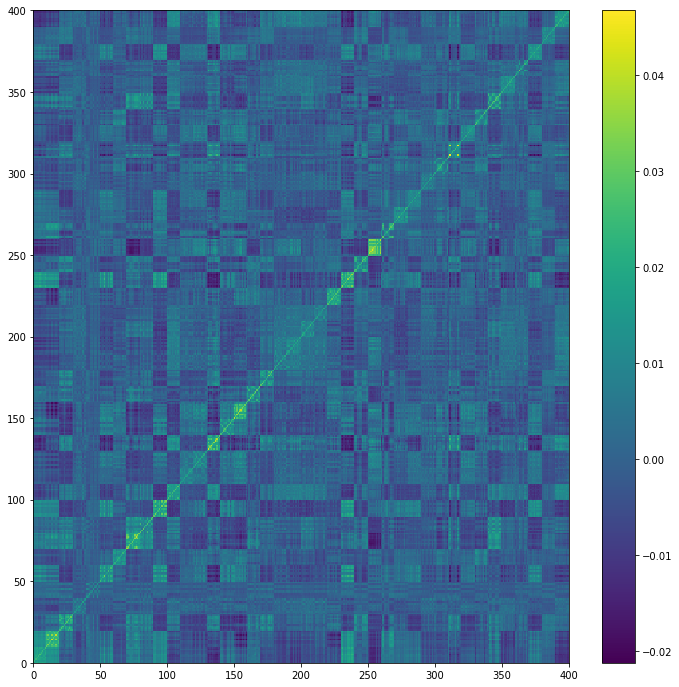

In [ ]:
plt.figure(figsize=(12,12))
plt.pcolor(C);
plt.colorbar();